In [22]:
%reset
import sys
sys.path.append("/Users/jason.wang/Desktop/hif2gene/scripts/helper_functions/") # replace path

# custom modules
import cluster_features_combine_p_values as cf
import hypothesis_testing as ht

# standard packages
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from copy import deepcopy
import scipy.stats as stats
import pickle as pkl

plt.rcParams['lines.markeredgewidth'] = 0

%reload_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## HIF Clusters (Defined Pan-Cancer)

In [23]:
# Load in HIF groupings based on agglomerative clustering with correlation distance
# Computed on pan-cancer patient-level dataset after removing rows with high NA (missingness)
working_dir = "~/Desktop/hif2gene"
hif_clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(working_dir))
hif_clusters.shape
hif_clusters = hif_clusters.rename(columns={"Unnamed: 0": "HIF", "x": "Cluster Group"})
hif_clusters

,HIF,Cluster Group
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,9


In [24]:
# Number of unique clusters
len(set(hif_clusters['Cluster Group']))

20

In [25]:
# Generate HIF to cluster map
hif2cluster = {}
for ind in hif_clusters.index: 
     hif2cluster[hif_clusters['HIF'][ind]] = hif_clusters['Cluster Group'][ind]
# hif2cluster

# Pan-Cancer

In [26]:
# Load in Pancancer HIF + immune expression signature data
pancancer_df = pd.read_csv("{0}/data/genetic_data/PanImmune/processed/pancancer.pan.immune.joined.csv".format(working_dir))
pancancer_df.shape # includes HIFs, clinical metadata, immune expression scores

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (632,643) have mixed types.Specify dtype option on import or set low_memory=False.



(2213, 822)

In [27]:
# Extract HIF columns
pancancer_hifs = pancancer_df.iloc[:, 4:611]
pancancer_hifs.shape
pancancer_hifs.columns

Index(['AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE',
       'AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE',
       'AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE',
       'AREA (MM2) OF [STROMA] IN [TISSUE]_HE',
       'AREA (MM2) OF [TUMOR] IN [TISSUE]_HE',
       'AREA PROP [[EPITHELIAL] OVER [TUMOR]] IN [TISSUE]_HE',
       'AREA PROP [[ESI_0080] OVER [TUMOR]] IN [TISSUE]_HE',
       'AREA PROP [[STROMA] OVER [TUMOR]] IN [TISSUE]_HE',
       'CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN EPITHELIAL_HE',
       'CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN ESI_0080_HE',
       ...
       'TOTAL [LYMPHOCYTE CELLS] IN [STROMA]_HE',
       'TOTAL [LYMPHOCYTE CELLS] IN [TUMOR]_HE',
       'TOTAL [MACROPHAGE CELLS] IN [EPITHELIAL]_HE',
       'TOTAL [MACROPHAGE CELLS] IN [ESI_0080]_HE',
       'TOTAL [MACROPHAGE CELLS] IN [STROMA]_HE',
       'TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE',
       'TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE',
       'TOTAL [PLASMA CELLS] IN [ESI_0080]_HE

In [28]:
# Extract immune expression columns of interest
expressions_of_interest = [
    'LIexpression_score', # Leukocyte infiltration
    'TGFB_score_21050467', # TGF-beta
    'CHANG_CORE_SERUM_RESPONSE_UP', # Wound healing signature          
    'IgG_19272155' #IgG expression
]
pancancer_expressions = pancancer_df[expressions_of_interest]
pancancer_expressions.shape
pancancer_expressions.columns

Index(['LIexpression_score', 'TGFB_score_21050467',
       'CHANG_CORE_SERUM_RESPONSE_UP', 'IgG_19272155'],
      dtype='object')

In [29]:
# Merge dataset 
pancancer_df_cleaned = pd.concat([pancancer_hifs.reset_index(drop=True), pancancer_expressions], axis=1)
pancancer_df_cleaned.shape
pancancer_df_cleaned.columns

# Add column linking patient samples back to cancer subtype
brca_n = 1027 # number patients
stad_n = 331
luad_n = 391
lusc_n = 400
skcm_n = 64
cancer_subtype = ['BRCA']*brca_n + ['STAD']*stad_n + ['LUAD']*luad_n + ['LUSC']*lusc_n + ['SKCM']*skcm_n

pancancer_df_cleaned['CancerSubtype'] = cancer_subtype
cancer_subtype_cmap = {
    'BRCA': '#f49ff2', 
    'STAD': '#4a91cd', 
    'LUAD': '#ea4253', 
    'LUSC': '#ec924a', 
    'SKCM': '#7c44cc'
}

In [30]:
# Remove rows with high NA (missingness)
pancancer_df_cleaned = pancancer_df_cleaned.dropna(axis="rows") # as expected, 5 rows removed
pancancer_df_cleaned.shape

(2202, 612)

In [31]:
# Spearman vs. Pearson Correlation
# Spearman: evaluate MONOTONIC relationship between two continuous variables, based on ranked values rather than raw data
# Pearson: evaluate LINEAR relationship between two continuous variables
pancancer_spearman_corr = pancancer_df_cleaned.corr(method='spearman')
pancancer_pearson_corr = pancancer_df_cleaned.corr(method='pearson')

In [32]:
colors = {
    'BRCA': '#f49ff2', 
    'STAD': '#4a91cd', 
    'LUAD': '#ea4253', 
    'LUSC': '#ec924a', 
    'SKCM': '#7c44cc' 
}

## Plot Leukocyte Infiltration Joint Plot

Spearman: 0.5441103622405717
Pearson: 0.4328837211758959


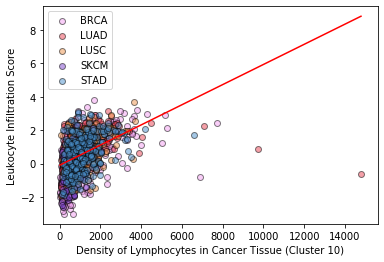

In [33]:
# Try plotting by cancer subtype
hif_name = 'DENSITY [LYMPHOCYTE CELLS] IN [TUMOR]_HE'
y_name = 'LIexpression_score'
hif = np.array(pancancer_df_cleaned[hif_name])
y = np.array(pancancer_df_cleaned[y_name])
cancer_subtypes = pancancer_df_cleaned['CancerSubtype']

for cancer_subtype in np.unique(cancer_subtypes):
    ix = np.where(cancer_subtypes == cancer_subtype)
    plt.scatter(hif[ix], y[ix], c=cancer_subtype_cmap[cancer_subtype], 
                label=cancer_subtype, edgecolors='black', alpha=0.5)

plt.plot(np.unique(hif), np.poly1d(np.polyfit(hif, y, 1))(np.unique(hif)), color='r')
plt.legend()
plt.ylabel('Leukocyte Infiltration Score')
plt.xlabel('Density of Lymphocytes in Cancer Tissue (Cluster 10)')

print("Spearman: {0}".format(pancancer_spearman_corr.iloc[pancancer_df_cleaned.columns.get_loc(hif_name), pancancer_df_cleaned.columns.get_loc(y_name)]))
print("Pearson: {0}".format(pancancer_pearson_corr.iloc[pancancer_df_cleaned.columns.get_loc(hif_name), pancancer_df_cleaned.columns.get_loc(y_name)]))

In [34]:
jointplot_df = pd.DataFrame({
    'Density of Lymphocytes in Cancer Tissue (Cluster 10)': hif, 
    'Leukocyte Infiltration Score': y,
    'Cancer Subtype': cancer_subtypes
})
# jointplot_df

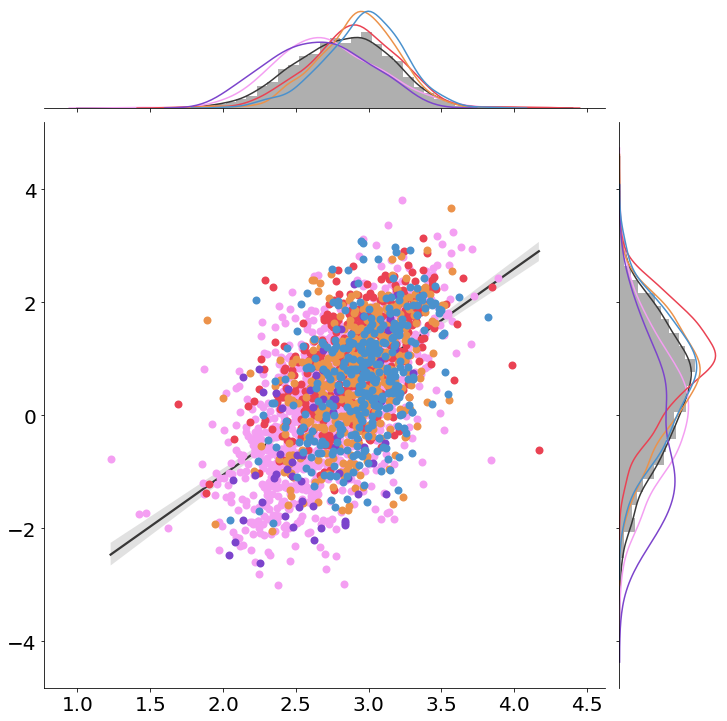

In [35]:
# Plot joint plot with normal axis
g = sns.jointplot(np.log10(hif), y, kind='reg', scatter = False, height=10, color='#393838')
for i, subdata in jointplot_df.groupby("Cancer Subtype"):
    sns.kdeplot(np.log10(subdata['Density of Lymphocytes in Cancer Tissue (Cluster 10)']), 
                ax=g.ax_marg_x, legend=False, color=colors[i])
    sns.kdeplot(subdata['Leukocyte Infiltration Score'], 
                ax=g.ax_marg_y, vertical=True, legend=False, color=colors[i])
    g.ax_joint.plot(np.log10(subdata['Density of Lymphocytes in Cancer Tissue (Cluster 10)']), 
                    subdata['Leukocyte Infiltration Score'], "o", ms = 8, 
                    color=colors[i], alpha=1.0, linewidth=1)
plt.tight_layout()
plt.tick_params(labelsize=20)
plt.show()

## Plot IgG Expression Joint Plot

Spearman: 0.6239752414939402
Pearson: 0.5271439346756117


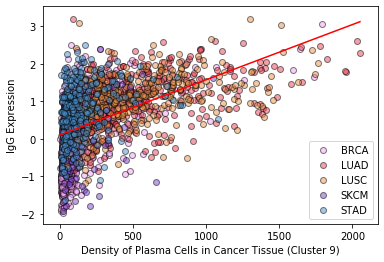

In [36]:
# Try plotting by cancer subtype
hif_name = 'DENSITY [PLASMA CELLS] IN [TUMOR]_HE'
y_name = 'IgG_19272155'
hif = np.array(pancancer_df_cleaned[hif_name])
y = np.array(pancancer_df_cleaned[y_name])
cancer_subtypes = pancancer_df_cleaned['CancerSubtype']

for cancer_subtype in np.unique(cancer_subtypes):
    ix = np.where(cancer_subtypes == cancer_subtype)
    plt.scatter(hif[ix], y[ix], c=cancer_subtype_cmap[cancer_subtype], 
                label=cancer_subtype, edgecolors='black', alpha=0.5)

plt.plot(np.unique(hif), np.poly1d(np.polyfit(hif, y, 1))(np.unique(hif)), color='r')
plt.legend()
plt.ylabel('IgG Expression')
plt.xlabel('Density of Plasma Cells in Cancer Tissue (Cluster 9)')

print("Spearman: {0}".format(pancancer_spearman_corr.iloc[pancancer_df_cleaned.columns.get_loc(hif_name), pancancer_df_cleaned.columns.get_loc(y_name)]))
print("Pearson: {0}".format(pancancer_pearson_corr.iloc[pancancer_df_cleaned.columns.get_loc(hif_name), pancancer_df_cleaned.columns.get_loc(y_name)]))

In [38]:
jointplot_df = pd.DataFrame({
    'Density of Plasma Cells in Cancer Tissue (Cluster 9)': hif, 
    'IgG Expression': y,
    'Cancer Subtype': cancer_subtypes
})
# jointplot_df

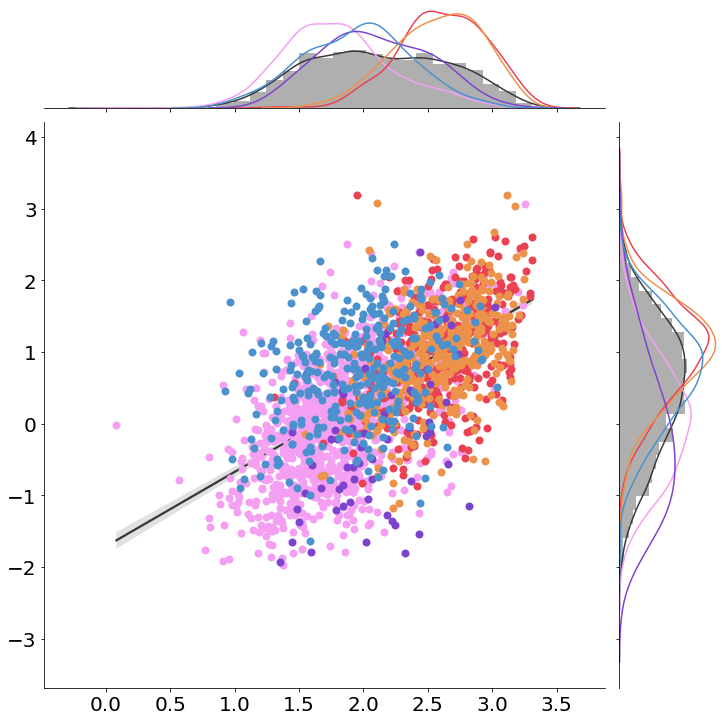

In [39]:
# Plot joint plot with normal axis
g = sns.jointplot(np.log10(hif), y, kind='reg', scatter = False, height=10, color='#393838')
for i, subdata in jointplot_df.groupby("Cancer Subtype"):
    sns.kdeplot(np.log10(subdata['Density of Plasma Cells in Cancer Tissue (Cluster 9)']), 
                ax=g.ax_marg_x, legend=False, color=colors[i])
    sns.kdeplot(subdata['IgG Expression'], 
                ax=g.ax_marg_y, vertical=True, legend=False, color=colors[i])
    g.ax_joint.plot(np.log10(subdata['Density of Plasma Cells in Cancer Tissue (Cluster 9)']), 
                    subdata['IgG Expression'], "o", ms = 8, 
                    color=colors[i], alpha=1.0, linewidth=1)
plt.tight_layout()
plt.tick_params(labelsize=20)
plt.show()

## Plot TGF-Beta Expression

Spearman: 0.3419061031887351
Pearson: 0.3022012978400152


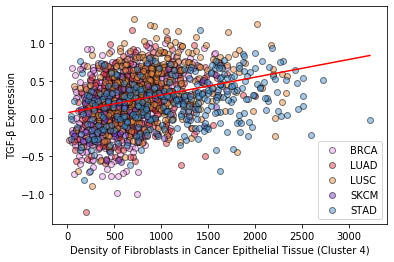

In [40]:
# Try plotting by cancer subtype
hif_name = 'DENSITY [FIBROBLAST CELLS] IN [TUMOR]_HE'
y_name = 'TGFB_score_21050467'
hif = np.array(pancancer_df_cleaned[hif_name])
y = np.array(pancancer_df_cleaned[y_name])
cancer_subtypes = pancancer_df_cleaned['CancerSubtype']

for cancer_subtype in np.unique(cancer_subtypes):
    ix = np.where(cancer_subtypes == cancer_subtype)
    plt.scatter(hif[ix], y[ix], c=cancer_subtype_cmap[cancer_subtype], 
                label=cancer_subtype, edgecolors='black', alpha=0.5)

plt.plot(np.unique(hif), np.poly1d(np.polyfit(hif, y, 1))(np.unique(hif)), color='r')
plt.legend()
plt.ylabel('TGF-β Expression')
plt.xlabel('Density of Fibroblasts in Cancer Epithelial Tissue (Cluster 4)')

print("Spearman: {0}".format(pancancer_spearman_corr.iloc[pancancer_df_cleaned.columns.get_loc(hif_name), pancancer_df_cleaned.columns.get_loc(y_name)]))
print("Pearson: {0}".format(pancancer_pearson_corr.iloc[pancancer_df_cleaned.columns.get_loc(hif_name), pancancer_df_cleaned.columns.get_loc(y_name)]))

In [41]:
jointplot_df = pd.DataFrame({
    'Density of Fibroblasts in Cancer Epithelial Tissue (Cluster 4)': hif, 
    'TGF-β Expression': y,
    'Cancer Subtype': cancer_subtypes
})
# jointplot_df

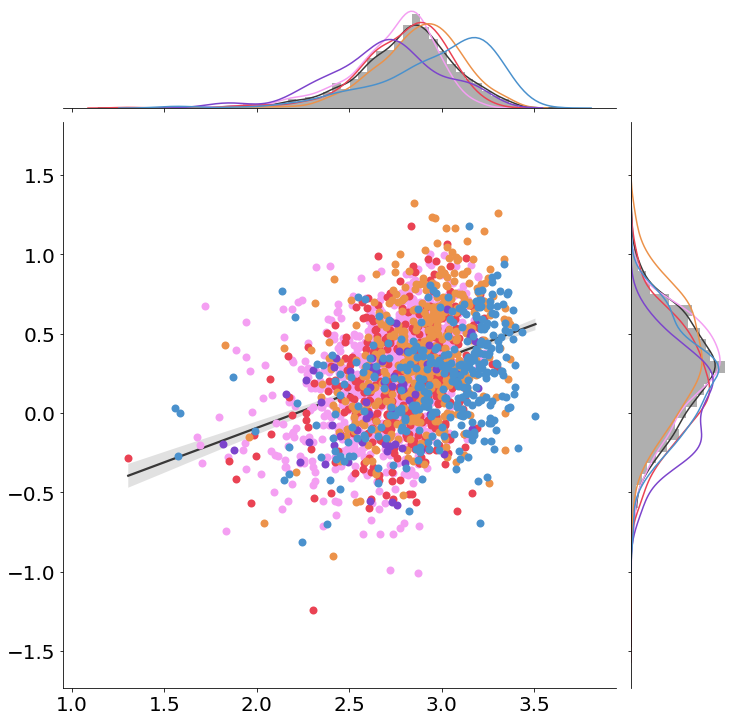

In [42]:
# Plot joint plot with normal axis
g = sns.jointplot(np.log10(hif), y, kind='reg', scatter = False, height=10, color='#393838')
for i, subdata in jointplot_df.groupby("Cancer Subtype"):
    sns.kdeplot(np.log10(subdata['Density of Fibroblasts in Cancer Epithelial Tissue (Cluster 4)']), 
                ax=g.ax_marg_x, legend=False, color=colors[i])
    sns.kdeplot(subdata['TGF-β Expression'], 
                ax=g.ax_marg_y, vertical=True, legend=False, color=colors[i])
    g.ax_joint.plot(np.log10(subdata['Density of Fibroblasts in Cancer Epithelial Tissue (Cluster 4)']), 
                    subdata['TGF-β Expression'], "o", ms = 8, 
                    color=colors[i], alpha=1.0, linewidth=1)
plt.tight_layout()
plt.tick_params(labelsize=20)
plt.show()

## Plot Wound Healing Signature

Spearman: 0.3623965036177435
Pearson: 0.23258124197848734


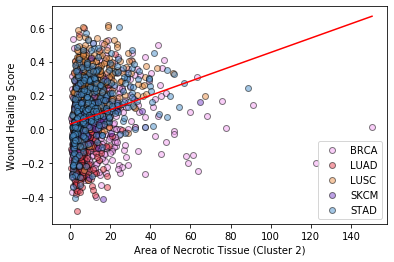

In [43]:
# Try plotting by cancer subtype
# hif_name = 'AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE'
hif_name = 'DENSITY RATIO [FIBROBLAST CELLS] IN [[STROMA] OVER [EPITHELIAL]]_HE'
y_name = 'CHANG_CORE_SERUM_RESPONSE_UP'
hif = np.array(pancancer_df_cleaned[hif_name])
y = np.array(pancancer_df_cleaned[y_name])
cancer_subtypes = pancancer_df_cleaned['CancerSubtype']

for cancer_subtype in np.unique(cancer_subtypes):
    ix = np.where(cancer_subtypes == cancer_subtype)
    plt.scatter(hif[ix], y[ix], c=cancer_subtype_cmap[cancer_subtype], 
                label=cancer_subtype, edgecolors='black', alpha=0.5)

plt.plot(np.unique(hif), np.poly1d(np.polyfit(hif, y, 1))(np.unique(hif)), color='r')
plt.legend()
plt.ylabel('Wound Healing Score')
plt.xlabel('Area of Necrotic Tissue (Cluster 2)')

print("Spearman: {0}".format(pancancer_spearman_corr.iloc[pancancer_df_cleaned.columns.get_loc(hif_name), pancancer_df_cleaned.columns.get_loc(y_name)]))
print("Pearson: {0}".format(pancancer_pearson_corr.iloc[pancancer_df_cleaned.columns.get_loc(hif_name), pancancer_df_cleaned.columns.get_loc(y_name)]))

In [44]:
jointplot_df = pd.DataFrame({
#     'Area of Necrotic Tissue (Cluster 2)': hif, 
    'Density (Fibroblasts in Cancer Stroma) / Density (Fibroblasts in Cancer Epithelial Tissue) (Cluster 12)': hif,
    'Wound Healing Score': y,
    'Cancer Subtype': cancer_subtypes
})
# jointplot_df

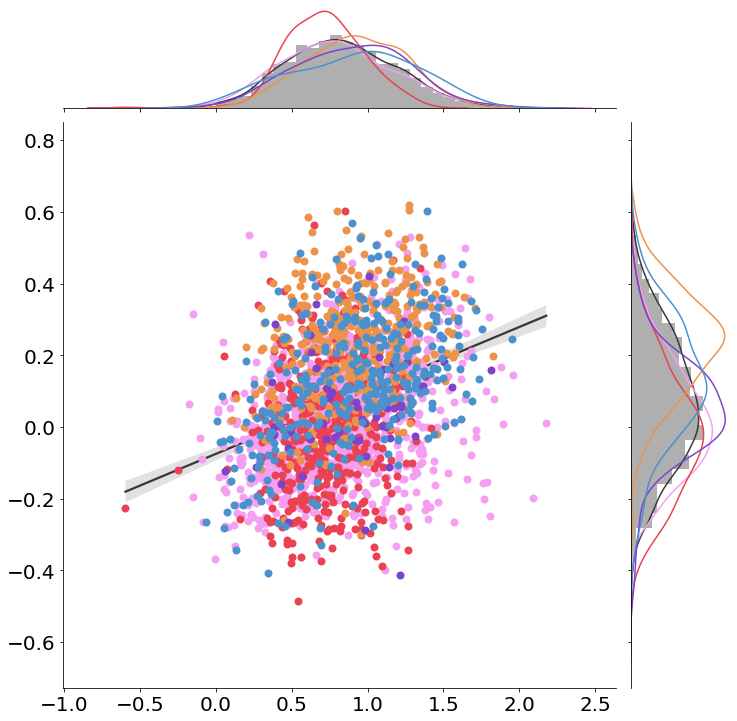

In [45]:
# Plot joint plot with normal axis
g = sns.jointplot(np.log10(hif), y, kind='reg', scatter = False, height=10, color='#393838')
for i, subdata in jointplot_df.groupby("Cancer Subtype"):
    sns.kdeplot(np.log10(subdata['Density (Fibroblasts in Cancer Stroma) / Density (Fibroblasts in Cancer Epithelial Tissue) (Cluster 12)']), 
                ax=g.ax_marg_x, legend=False, color=colors[i])
    sns.kdeplot(subdata['Wound Healing Score'], 
                ax=g.ax_marg_y, vertical=True, legend=False, color=colors[i])
    g.ax_joint.plot(np.log10(subdata['Density (Fibroblasts in Cancer Stroma) / Density (Fibroblasts in Cancer Epithelial Tissue) (Cluster 12)']), 
                    subdata['Wound Healing Score'], "o", ms = 8, 
                    color=colors[i], alpha=1.0, linewidth=1)
plt.tight_layout()
plt.tick_params(labelsize=20)
plt.show()

## Spearman Correlation Analysis

In [46]:
# Compute Spearman correlation + generate P-value
y_name = 'TGFB_score_21050467'
y = pancancer_df_cleaned[y_name]

# Iterate through columns of HIF dataframe
pancancer_df_spearman = pd.DataFrame()
hif_cluster_groups = list(hif_clusters['Cluster Group'])

for hif_name in pancancer_df_cleaned.iloc[:,0:607]:
    hif = pancancer_df_cleaned[hif_name]
    rho, pval = stats.spearmanr(hif, y)
    pancancer_df_spearman = pancancer_df_spearman.append(pd.DataFrame({
        "HIF": [hif_name],
        "Rho": [rho],
        "P-Value": [pval],
        "Cluster Group": [hif2cluster[hif_name]]
    }))

# Index dataframe by HIF name
pancancer_df_spearman = pancancer_df_spearman.set_index('HIF')

In [47]:
# pancancer_df_spearman.sort_values(by="Rho", ascending=False).iloc[1:50,:]

In [48]:
# HIFs are highly-correlated; thus P-values are correlated / dependent
# Apply the Empirical Brown's Method to combine P-values

# Normalize (convert to z-score) matrix (required as input)
pancancer_df_mu = pancancer_df_cleaned.iloc[:,0:607].mean().values # mean per HIF column
pancancer_df_sigma = pancancer_df_cleaned.iloc[:,0:607].std().values # standard deviation per HIF column
pancancer_df_normalized = (pancancer_df_cleaned.iloc[:,0:607] - pancancer_df_mu)/pancancer_df_sigma


# Generate combined P-values within HIF clusters
combined_pvals = cf.combine_p_values(np.array(hif_cluster_groups), pancancer_df_spearman, 
                                     pancancer_df_normalized, p_val_col='P-Value')

In [49]:
# False discovery rate / multiple hypothesis correction via Benjamini-Hochberg
significant, ebm_q_values = ht.bh_correction(combined_pvals, alpha=0.05) # Q-values = corrected P-values

In [50]:
# Compute summary statistics (e.g. median / mean absolute(rho)) per HIF cluster
# Recall that rho is a correlation coefficient (can +/-)
summary_median = pancancer_df_spearman.drop('P-Value', axis=1).apply(abs).groupby('Cluster Group').median()
# summary_mad = pancancer_df_spearman.drop('P-Value', axis=1).apply(abs).groupby('Cluster Group').mad()
summary_25th = pancancer_df_spearman.drop('P-Value', axis=1).apply(abs).groupby('Cluster Group').quantile(0.25)
summary_75th = pancancer_df_spearman.drop('P-Value', axis=1).apply(abs).groupby('Cluster Group').quantile(0.75)

# Merge stats
# summary = summary_median.join(summary_mad, lsuffix=' Median', rsuffix=' MAD')
summary = summary_median.join(summary_25th, lsuffix=' Median', rsuffix=' 25th Percentile')
summary = summary.join(summary_75th, lsuffix=' a', rsuffix=' 75th Percentile')
summary = summary.rename(columns={"Rho": "Rho 75th Percentile"})

In [51]:
# Create corrected P-value table
pancancer_combined_pvals_corrected = pd.DataFrame({
    "Cluster Group": range(1, len(combined_pvals)+1),
    "Combined P-Value": combined_pvals,
    "Q-Value": ebm_q_values # Corrected + Combined P-Value
})

# Join summary stats
pancancer_combined_pvals_corrected = pancancer_combined_pvals_corrected.merge(summary, on="Cluster Group")

In [52]:
pancancer_combined_pvals_corrected.sort_values(by="Rho Median", ascending=False)

,Cluster Group,Combined P-Value,Q-Value,Rho Median,Rho 25th Percentile,Rho 75th Percentile
3,4,0.000000e+00,0.000000e+00,0.308471,0.206670,0.320653
13,14,2.580575e-91,1.032230e-90,0.275856,0.240972,0.311826
11,12,8.181916e-105,4.090958e-104,0.247511,0.216446,0.287592
12,13,1.142963e-114,7.619752e-114,0.133684,0.053049,0.238498
2,3,8.691671e-65,2.172918e-64,0.111617,0.029978,0.152342
7,8,9.170202e-26,1.834040e-25,0.097259,0.051946,0.104258
10,11,2.282049e-124,2.282049e-123,0.093625,0.073995,0.204012
5,6,1.324064e-47,2.942364e-47,0.085626,0.068445,0.120587
15,16,7.096506e-78,2.365502e-77,0.085610,0.010691,0.167600
1,2,1.726666e-09,2.877776e-09,0.078754,0.047345,0.100062
